# 1. Initialization

## Imports

In [1]:
import math, random

import torch
import torch.nn as nn
from torch.nn import init, functional
from torch.utils.data import DataLoader, Dataset, random_split

import torchaudio
from torchaudio import transforms

from scipy.signal import filtfilt
from scipy import stats
import scipy

import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinarySpecificity
from sklearn import metrics

import pandas as pd
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
from os import walk

from packages.metrics_saver import update_metrics, get_metrics

In [2]:
#To allow plotting pytorch tensors
torch.Tensor.ndim = property(lambda self: len(self.shape))
#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## Constants

In [3]:
MODEL_NAME = 'SCRNN'
IMPORT = False  #Import model state_dict if available
MODEL_IMPORT_NAME = ''  + '.pth'
IMPORT_OPTIM = False

Hyperparameters

In [23]:
N_CLASSES = 2
N_EPOCHS = 2500
LEARNING_RATE = 0.0001
MAX_LR = 0.01
WEIGHT_DECAY = 0.001
STOP_EPOCHS = 100 # stop training if accuracy doesnt increase for 50 epochs
BATCH_SIZE = 64


In [24]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# 2. Audio Preprocessing Utilities

## Importing dataset

In [25]:
train_df = pd.read_csv('Dataset/PhysioNetPreprocessed/train/REFERENCES.csv')
val_df = pd.read_csv('Dataset/PhysioNetPreprocessed/validation/REFERENCES.csv')
test_df = pd.read_csv('Dataset/PhysioNetPreprocessed/test/REFERENCES.csv')

## Sound Dataset class
A custom dataset used to get new randomly preprocessed audio signals

In [26]:
class SoundDS(Dataset):
    # constructor
    def __init__(self, _df):
        super().__init__()
        self.df = _df
    
    # get length of ds
    def __len__(self):
        return len(self.df)
    
    # get i'th item in dataset
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'relative_path']  # get audio file path
        class_id = self.df.loc[idx, 'classID']          # get class id

        data = torch.load(audio_file)

        return data, class_id

## Random split
Split the dataset into 75% training set, 15% for validation, and 10% for testing using the 'random_split' function.

In [27]:
train_ds = SoundDS(train_df)
val_ds = SoundDS(val_df)
test_ds = SoundDS(test_df)

Visualizing different data from each class

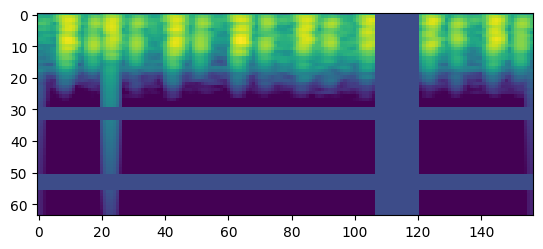

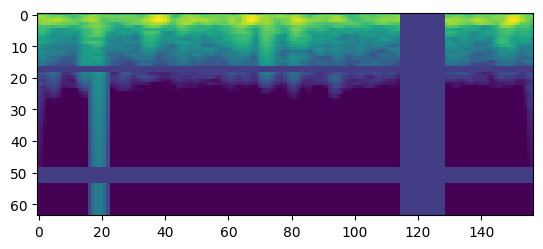

In [28]:
stop = [False, False]
for data, classid in val_ds:
    if(classid == 0):
        normal_data = data
        stop[0] = True
    if(classid == 1):
        abnormal_data = data
        stop[1] = True
    if(stop == [True, True]):
        break

plt.imshow(normal_data[0].cpu())
plt.show()
plt.imshow(abnormal_data[0].cpu())
plt.show()

## Data loaders

Creating a sampler to balance the dataset

In [29]:
class_weights = 1/ train_df['classID'].value_counts() # get number of samples in each class and invert it
sample_weights = pd.Series([0] * len(train_ds))          # initialize the sample_weights array

# WeightedRandomSampler takes an array that represents the weight of each sample.
sample_weights[train_df['classID'] == 0] = class_weights[0]
sample_weights[train_df['classID'] == 1] = class_weights[1]

sample_weights = sample_weights.values
sampler = torch.utils.data.WeightedRandomSampler(sample_weights,
                                                num_samples=len(sample_weights),
                                                replacement=True)


Create training, validation, and test data loaders

In [30]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, sampler=sampler)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

# 3. Audio Classification Model

## Creating a model instance
- Put it on the GPU if available
- Import a pretrained model if wanted

In [31]:
# importing model classes
from packages.SCRNN import SCRNN
myModel = SCRNN(1, 64, 2, device=device)
complexity = torch.nn.utils.convert_parameters.parameters_to_vector(myModel.parameters()).numel()
print("Model Complexity:",complexity)

Model Complexity: 2163842


c:\Users\aymen\OneDrive\Documents\Studies\INELEC\Master\Projects\cvd_classification\packages\SCRNN.py:31: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


## Creating save path
- create a save/import path for the pretrained model
- the parameters of the model are stored in this path
- the parameters of the optimizer are also stored

In [32]:
from pathlib import Path
MODEL_PATH = Path('models/' + MODEL_NAME)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_IMPORT_PATH = MODEL_PATH / MODEL_IMPORT_NAME
OPTIM_IMPORT_NAME = 'optim_' + MODEL_IMPORT_NAME
OPTIM_IMPORT_PATH = MODEL_PATH / OPTIM_IMPORT_NAME

if IMPORT:
    try:
        myModel.load_state_dict(torch.load(f=MODEL_IMPORT_PATH))
    except:
        print(MODEL_IMPORT_PATH + 'not found.') 

In [33]:
# send the model to the GPU
myModel = myModel.to(device)
# Check that it is on the GPU (cuda)
next(myModel.parameters()).device

device(type='cuda', index=0)

In [34]:
# testing the model's functionality on one batch
_, d = next(enumerate(train_dl))
print(d[0].shape)
myModel(d[0]).shape

torch.Size([64, 1, 64, 157])


torch.Size([64, 2])

# 4. Training Loop

## Training function

In [37]:
def training(model, train_dl, val_dl, N_EPOCHS):
    # Loss function, Optimizer and Scheduler
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=int(len(train_dl)), epochs=N_EPOCHS, anneal_strategy='linear')

    # metrics for visualization
    acc_fn = BinaryAccuracy().to(device)
    precision_fn = BinaryPrecision().to(device)
    speci_fn = BinarySpecificity().to(device)
    f1_fn = BinaryF1Score().to(device)
    
    best_val_acc = 0
    best_model_params = model.state_dict()
    epochs_since_improvement  = 0
    # Repeat for each epoch
    for epoch in range(N_EPOCHS):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        # Train step
        for i, data in enumerate(train_dl):
            # Get the input features and target labels and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()

            # forward + backward + optimize
            model.train()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            #keep stats for loss and accuracy
            running_loss += loss.item()

            # get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        # Validation step
        val_running_loss = 0
        model.eval()
        with torch.inference_mode():
            for _, val_data in enumerate(val_dl):
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                # Normalize the inputs
                val_inputs_m, val_inputs_s = val_inputs.mean(), val_inputs.std()
                val_inputs = (val_inputs - val_inputs_m) / val_inputs_s

                val_outputs = model(val_inputs)
                _, val_prediction = torch.max(val_outputs, 1)
                
                val_loss = loss_fn(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                acc_fn.update(val_prediction, val_labels)
                precision_fn.update(val_prediction, val_labels)
                speci_fn.update(val_prediction, val_labels)
                f1_fn.update(val_prediction, val_labels)
        
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        val_num_batches = len(val_dl)
        val_avg_loss = val_running_loss / val_num_batches
        val_acc = acc_fn.compute().item()
        precision = precision_fn.compute().item()
        speci = speci_fn.compute().item()
        f1 = f1_fn.compute().item()

        if val_acc > best_val_acc:
            # check for the previous max accuracy value
            best_val_acc = val_acc
            best_model_params = model.state_dict()
            epochs_since_improvement = 0

        elif epochs_since_improvement > STOP_EPOCHS:
            # stop early if validation accuracy doesnt improve for 'STOP_EPOCHS' epochs
            print(f"{bcolors.WARNING}Training stopped as validation accuracy did not improve in the last {STOP_EPOCHS} epochs.{bcolors.ENDC}")
            break
        else:
            epochs_since_improvement += 1

        if epoch % 1 == 0:
            print(f'{bcolors.OKBLUE}Epoch: {epoch}, Train Loss: {avg_loss:.2f}, Validation Loss: {val_avg_loss:.2f}, Train Accuracy: {acc:.2f}, Validation Accuracy: {val_acc:.2f}{bcolors.ENDC}')
            # save metrics to a .csv file
            update_metrics(MODEL_NAME, val_acc, val_avg_loss, acc, avg_loss, precision, speci, f1 )
        if epoch % (N_EPOCHS / 10) == 0:
            # save model params and optimizer internal state every 10% epochs
            MODEL_NAME_PTH = MODEL_NAME + '_' + str(val_acc) + '.pth'
            OPTIM_PTH = 'optim_' + MODEL_NAME + '_' + str(val_acc) + '.pth'
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_PTH
            OPTIM_SAVE_PATH = MODEL_PATH / OPTIM_PTH
            print(f"Saving model to {MODEL_SAVE_PATH}")
            torch.save(obj=myModel.state_dict(), f=MODEL_SAVE_PATH)
            torch.save(obj=optimizer.state_dict(), f=OPTIM_SAVE_PATH)
    
    print(f"{bcolors.OKGREEN}Finished Training{bcolors.ENDC}")
    return best_model_params

## Start training

In [38]:
best_model = training(myModel, train_dl, val_dl, N_EPOCHS)

Epoch: 0, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.49, Validation Accuracy: 0.21
Saving model to models\SCRNN\SCRNN_0.20576131343841553.pth
Epoch: 1, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.51, Validation Accuracy: 0.50
Epoch: 2, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.48, Validation Accuracy: 0.60
Epoch: 3, Train Loss: 0.69, Validation Loss: 0.70, Train Accuracy: 0.49, Validation Accuracy: 0.50
Epoch: 4, Train Loss: 0.69, Validation Loss: 0.70, Train Accuracy: 0.49, Validation Accuracy: 0.44
Epoch: 5, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.49, Validation Accuracy: 0.40
Epoch: 6, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.50, Validation Accuracy: 0.46
Epoch: 7, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.49, Validation Accuracy: 0.50
Epoch: 8, Train Loss: 0.69, Validation Loss: 0.69, Train Accuracy: 0.49, Validation Accuracy: 0.47
Epoch: 9, Train Loss: 0.69, Validation Loss: 0.69,

In [39]:
# set model params to the best ones
myModel.load_state_dict(best_model)

<All keys matched successfully>

Visualize metrics

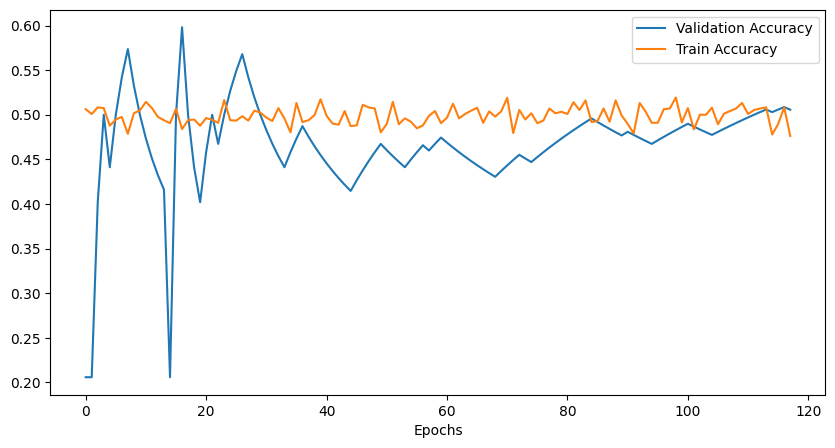

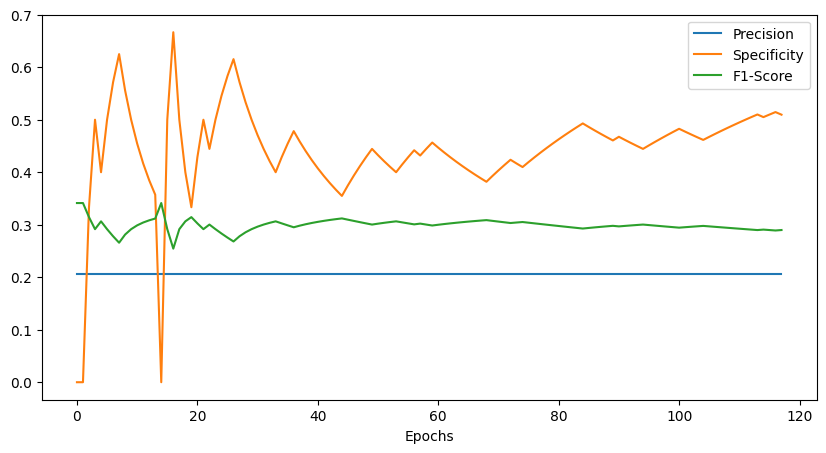

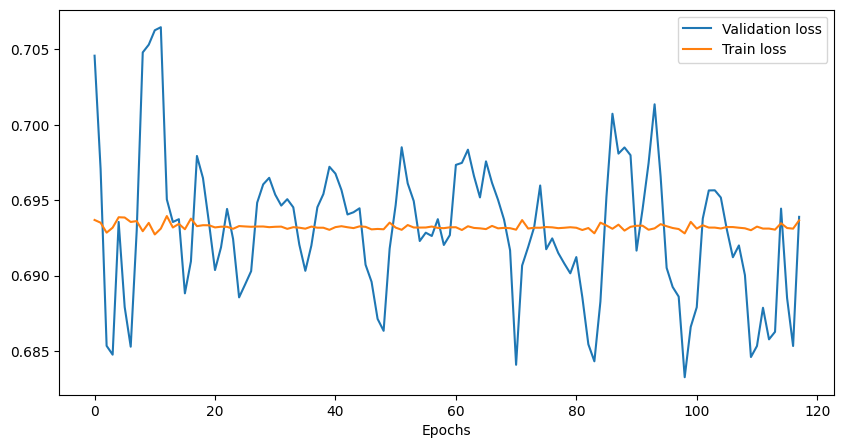

In [40]:
train_metrics = get_metrics(MODEL_NAME)

plt.figure(figsize=(10, 5))
plt.xlabel("Epochs")
plt.plot(train_metrics.index ,train_metrics['validation_acc'], label='Validation Accuracy')
plt.plot(train_metrics.index ,train_metrics['train_accuracy'], label='Train Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")

plt.plot(train_metrics.index, train_metrics['precision'], label='Precision')
plt.plot(train_metrics.index, train_metrics['specificity'], label='Specificity')
plt.plot(train_metrics.index, train_metrics['f1-score'], label='F1-Score')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.plot(train_metrics.index, train_metrics['validation_loss'], label='Validation loss')
plt.plot(train_metrics.index, train_metrics['train_loss'], label='Train loss')
plt.legend()

Save the model after the training is complete

In [41]:
MODEL_NAME_PTH = MODEL_NAME + '_final.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_PTH
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=myModel.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\SCRNN\SCRNN_final.pth


# 5. Evaluation
Run inference on the trained model with the test set and compute metrics

In [42]:
def inference(model, val_dl):
    confmat_fn = torchmetrics.ConfusionMatrix(task="binary", num_classes=N_CLASSES).to(device)
    acc_fn = BinaryAccuracy().to(device)
    precision_fn = BinaryPrecision().to(device)
    speci_fn = BinarySpecificity().to(device)
    f1_fn = BinaryF1Score().to(device)

    with torch.inference_mode():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)

            acc_fn.update(prediction, labels)
            precision_fn.update(prediction, labels)
            speci_fn.update(prediction, labels)
            f1_fn.update(prediction, labels)
            confmat_fn.update(prediction, labels)
        
        acc = acc_fn.compute().item()
        precision = precision_fn.compute().item()
        speci = speci_fn.compute().item()
        f1 = f1_fn.compute().item()
        confmat = confmat_fn.compute()
        print(f'Accuracy: {acc:.2f}, Precision: {precision:.2f}, Specificity: {speci:.2f}, F1 Score: {f1:.2f}')
        cm_display = metrics.ConfusionMatrixDisplay(confmat.cpu().numpy(), display_labels=['Normal', 'Abnormal'])
        cm_display.plot()

Accuracy: 0.22, Precision: 0.22, Specificity: 0.00, F1 Score: 0.36


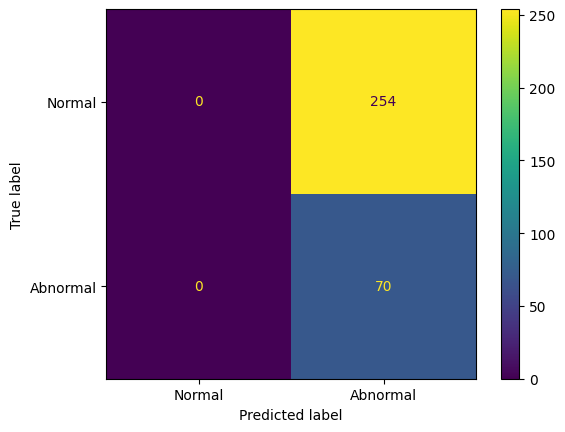

In [43]:
inference(myModel, test_dl)

# 6. Testing

In [44]:
def testing(model, data):
    model.eval()
    with torch.inference_mode():
        input = data[0].unsqueeze(dim=0).to(device)
        label = torch.tensor(data[1]).to(device)
        inputs_m, inputs_s = input.mean(), input.std()
        input = (input - inputs_m) / inputs_s
        output = model(input)
        _, prediction = torch.max(output,1)
        if prediction == label:
            print(f"{bcolors.OKGREEN}{prediction[0].item()} <--> {label}{bcolors.ENDC}")
        else:
            print(f"{bcolors.FAIL}{prediction[0].item()} <--> {label}{bcolors.ENDC}")
        

print(f"{bcolors.BOLD}predicted <--> actual{bcolors.ENDC}")
for i in range(len(val_ds)):
    testing(myModel, val_ds[i])

predicted <--> actual
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 1
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 0
1 <--> 1
1 <-->

Testing predictions on self recorded audio

In [45]:
def predict(model, audio_file):
    model.eval()
    with torch.inference_mode():
        aud, _, aug_spec, mfcc, delta_mfcc, delta2_mfcc = AudioUtil.preprocess_audio(audio_file)
        mfcc_cat = torch.cat([mfcc, delta_mfcc, delta2_mfcc], dim=1)
        AudioUtil.display_spectrogram(aug_spec.cpu())
        AudioUtil.display_MFCC(mfcc.cpu(), label='MFCC', type='graph')
        AudioUtil.display_MFCC(delta_mfcc.cpu(), label='1st order MFCC', type='graph')
        AudioUtil.display_MFCC(delta2_mfcc.cpu(), label='2nd order MFCC', type='graph')
        # data = mfcc_cat.unsqueeze(dim=0)
        data = aug_spec.unsqueeze(dim=0)
        return model(data).argmax().item()

predict(myModel, 'Heart 2.wav')

NameError: name 'AudioUtil' is not defined